# Developing Brain Atlas through Deep Learning 

## A. Iqbal, R. Khan, T. Karayannis
# .
# .
# .

## Import libraries here
## Install missing libraries

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from config import Config
from config import BrainConfig
import utils
import visualize
from visualize import display_images
from visualize import get_ax
import model as modellib
from model import log
import glob #for selecting png files in training images folder
from natsort import natsorted, ns #for sorting filenames in a directory
import skimage
from skimage import io
from skimage import transform

# Import testing dataset 
from brain_dataset import BrainDataset_Val

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
BRAIN_MODEL_PATH = os.path.join(ROOT_DIR, "SeBRe_FINAL_WEIGHTS.h5")


c:\users\asfandyar\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

In [2]:
config = BrainConfig()
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

## Notebook Preferences

In [3]:
# Device to load the neural network on.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in inference modes
TEST_MODE = "inference"

## Load Dataset

In [4]:
# Build validation dataset
dataset_val = BrainDataset_Val()
dataset_val.load_brain()
dataset_val.prepare()
dataset = dataset_val

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 200
Classes: ['BG', 'cortex:', 'hippocampus:', 'basal ganglia:', 'thalamus:', 'prethalamus:', 'midbrain:', 'hindbrain:', 'telencephalic vesicle:']


## Load Model

In [5]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# Set weights file path
weights_path = BRAIN_MODEL_PATH

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  C:\Users\Asfandyar\Documents\Romesa\Scene_Parsing\Code\Mask_RCNN\NatMachIntell_Code_FINAL\SeBRe_FINAL_WEIGHTS.h5


## Supplementary Figure 4: SeBRe multistage image processing pipeline
# .
# .

### Supplementary Figure 4(a): Bounding-boxes of ground-truth targets, generated for Region Proposal Network (RPN)

In [6]:
image_id = 150
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)


original image shape:  (2192, 3616, 3)


C:\Users\Asfandyar\AppData\Roaming\Python\Python35\site-packages\scipy\ndimage\interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [7]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (36828,)              min:   -1.00000  max:    1.00000
target_rpn_bbox          shape: (256, 4)              min:   -2.18750  max:    3.21019
positive_anchors         shape: (8, 4)                min:  -26.50967  max:  333.25483
negative_anchors         shape: (248, 4)              min:  -11.31371  max:  385.65685
neutral anchors          shape: (36572, 4)            min:  -90.50967  max:  410.50967
refined_anchors          shape: (8, 4)                min:   18.00000  max:  337.00000


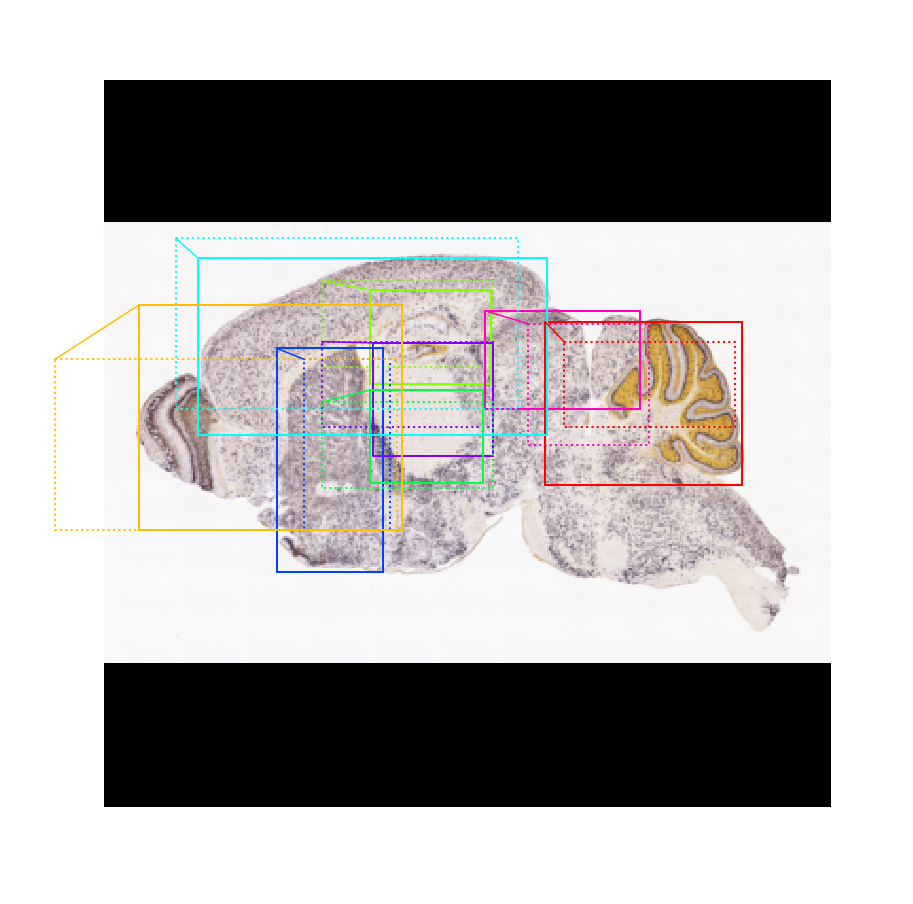

In [8]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### Supplementary Figure 4(b): Boxes for proposed regions predicted by RPN

In [9]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 introduces a new version of NMS. Search for both names to support TF 1.3 and 1.4
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 36828, 2)         min:    0.00000  max:    1.00000
pre_nms_anchors          shape: (1, 6000, 4)          min:  -90.50967  max:  410.50967
refined_anchors          shape: (1, 6000, 4)          min: -219699.29688  max: 219779.70312
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:  384.00000
post_nms_anchor_ix       shape: (1000,)               min:    0.00000  max: 3227.00000
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000


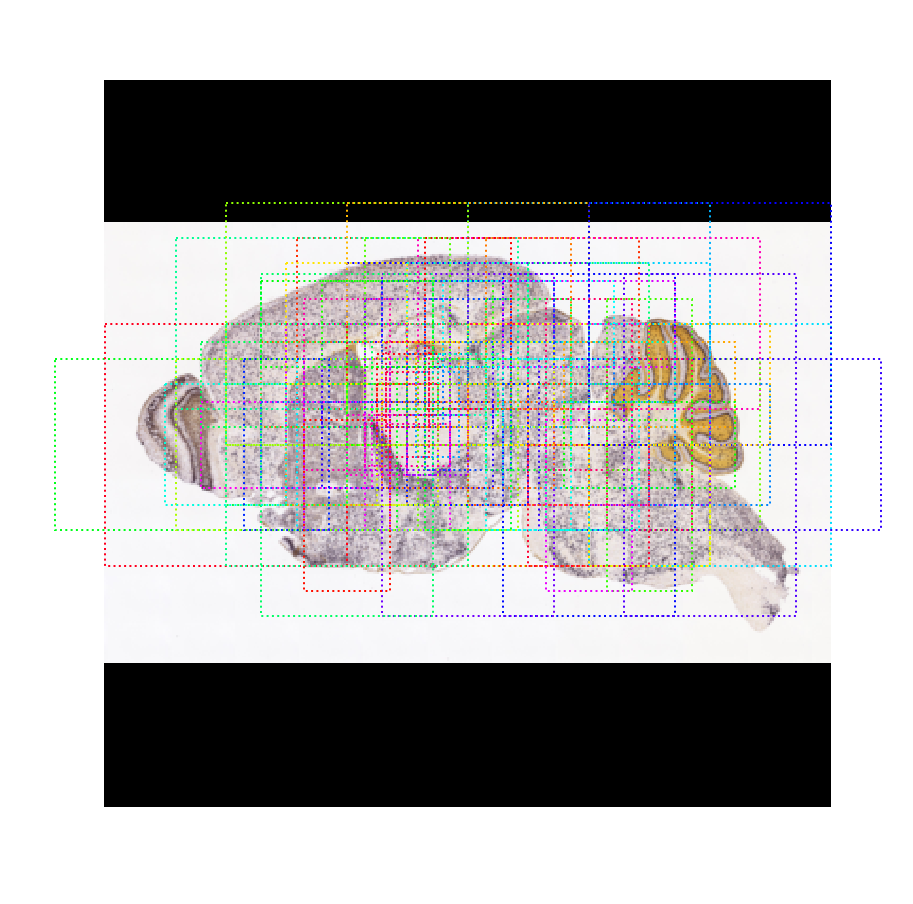

In [10]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

### Supplementary Figure 4(c): RPN-predicted anchors after refinement 
### &
### Supplementary Figure 4(d): RPN-predicted anchors after clipping to boundaries

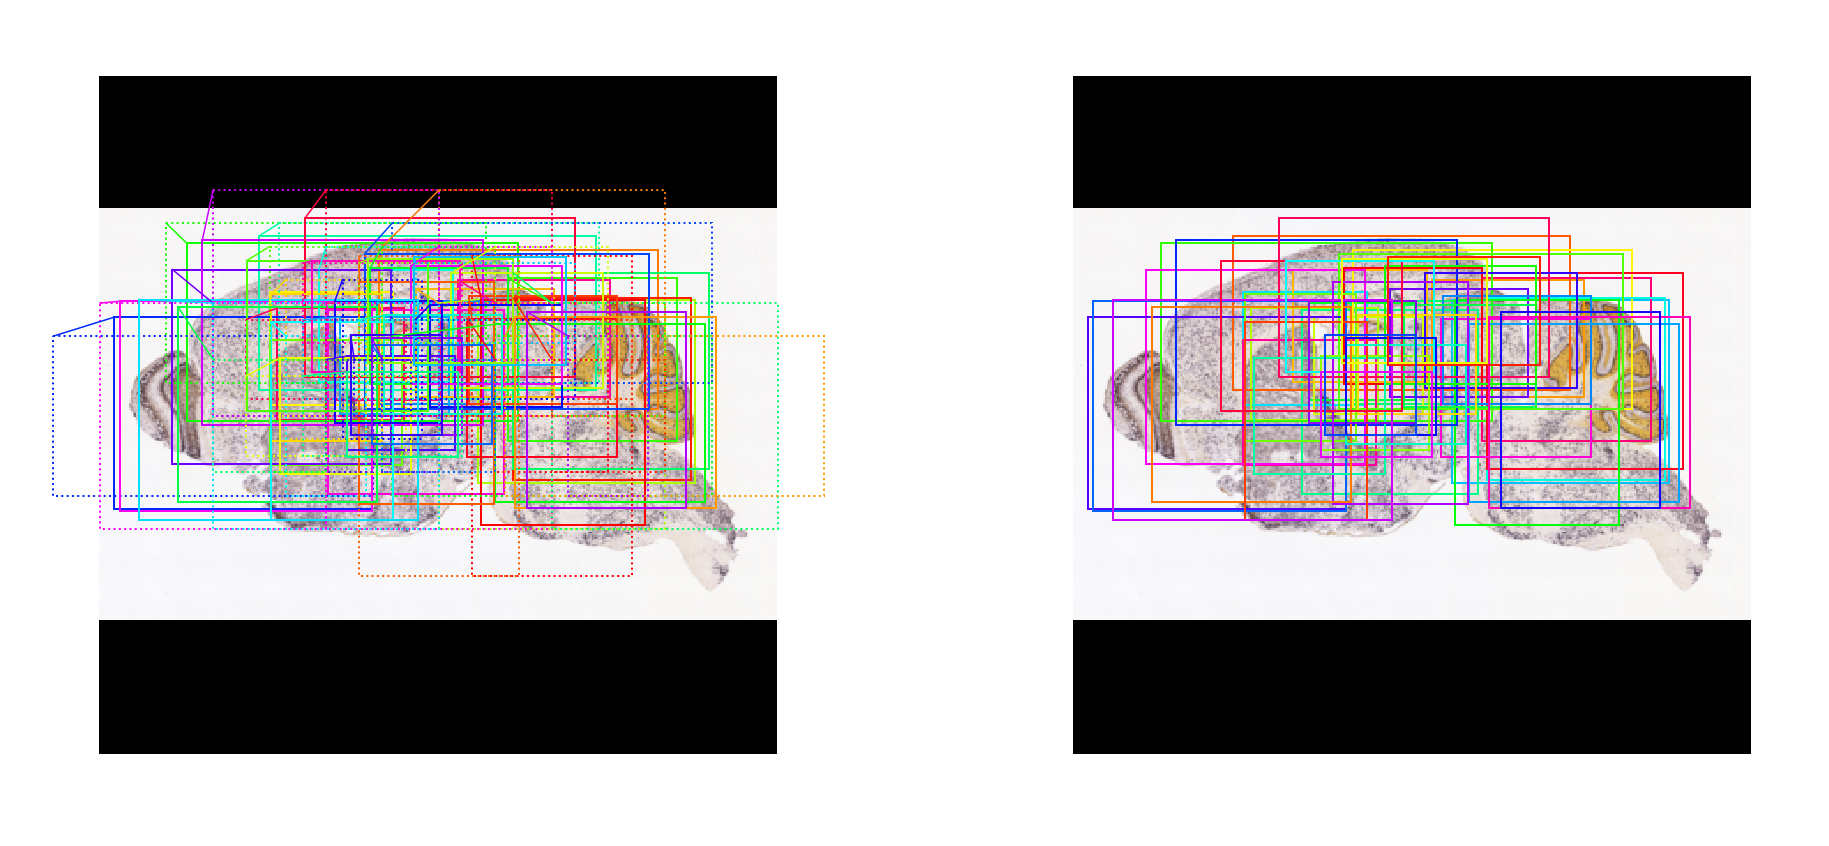

In [11]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
visualize.draw_boxes(image, boxes=rpn["pre_nms_anchors"][0, :limit], 
           refined_boxes=rpn["refined_anchors"][0, :limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, :limit], ax=ax[1])

### Supplementary Figure 4(e): RPN-predicted anchors after non-maximum suppression

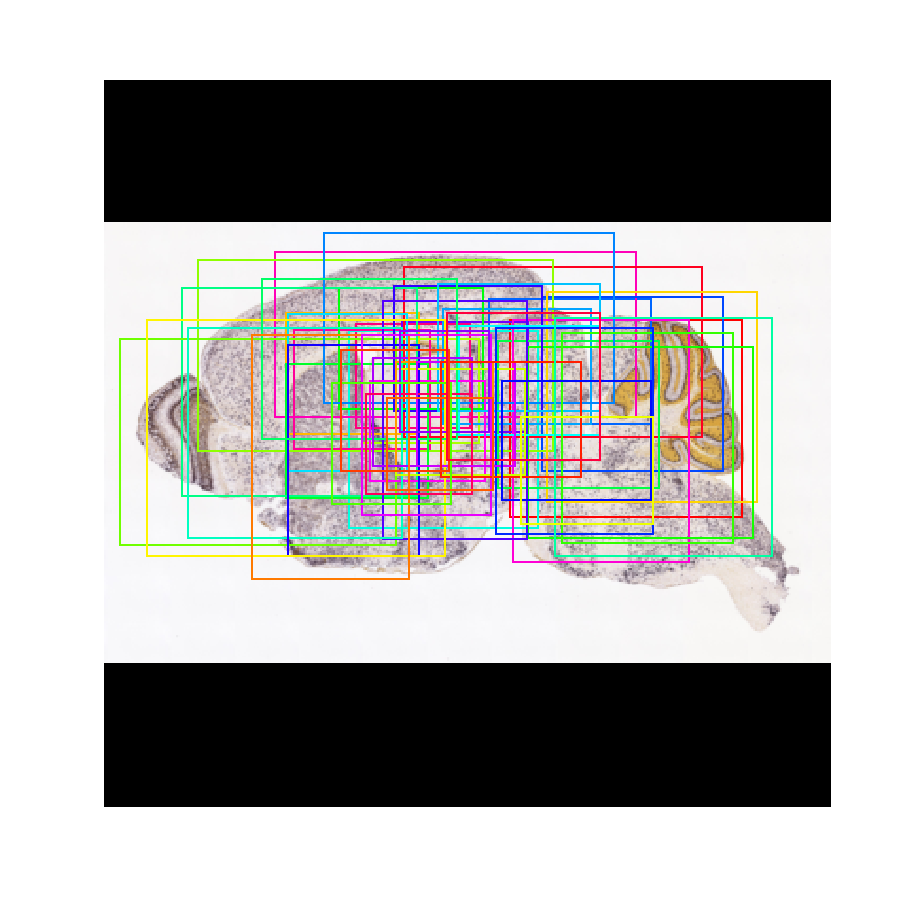

In [12]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, ixs], ax=get_ax())

### Supplementary Figure 4(f): RPN-predicted anchors after coordinate normalization

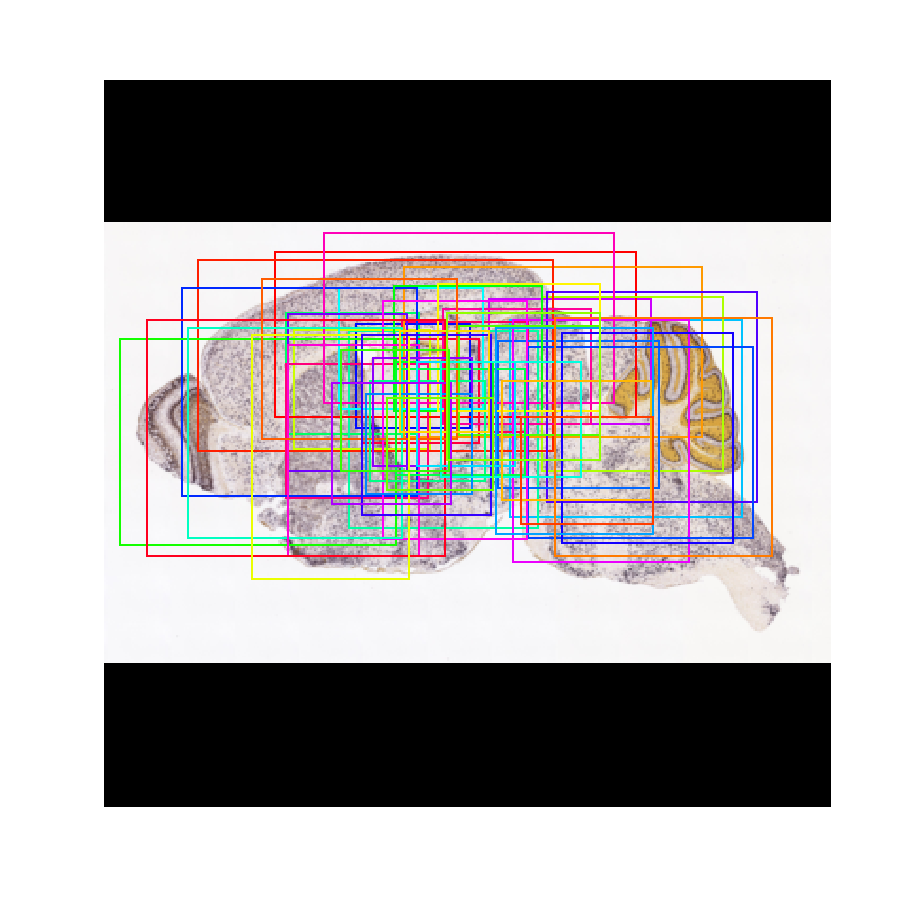

In [13]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

### Supplementary Figure 4(g): Predictions of FPN-classifier heads on RPN-predicted anchors

In [14]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000
probs                    shape: (1, 1000, 9)          min:    0.00000  max:    1.00000
deltas                   shape: (1, 1000, 9, 4)       min:   -6.87059  max:    5.53694
masks                    shape: (1, 8, 28, 28, 9)     min:    0.00000  max:    1.00000
detections               shape: (1, 8, 6)             min:    0.97652  max:  334.00000


In [85]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
138 Positive ROIs
[('BG', 862), ('basal ganglia:', 10), ('cortex:', 20), ('hindbrain:', 13), ('hippocampus:', 17), ('midbrain:', 10), ('prethalamus:', 16), ('telencephalic vesicle:', 17), ('thalamus:', 35)]


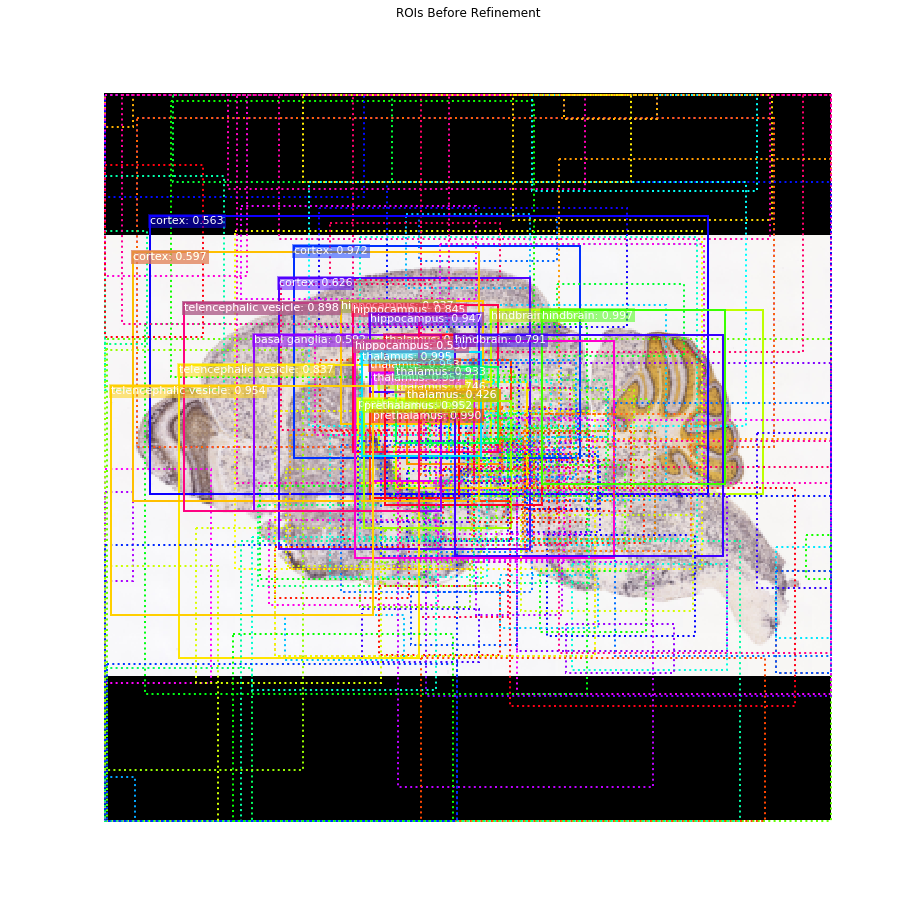

In [86]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

### Supplementary Figure 4(h): FPN-predicted classes after anchor-refinement

roi_bbox_specific        shape: (1000, 4)             min:   -6.87059  max:    3.88072
refined_proposals        shape: (1000, 4)             min:   -7.00000  max:  419.00000


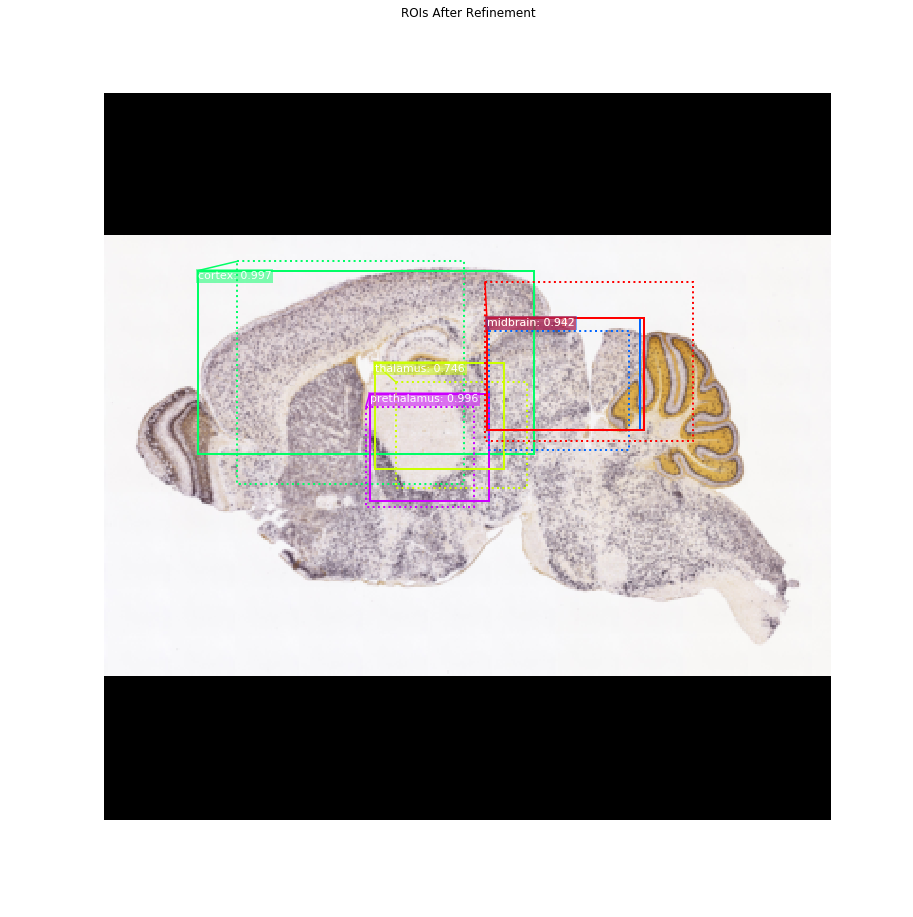

In [87]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

### Supplementary Figure 4(i): Final brain region detections of FPN regressor and classifier heads

In [88]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000
probs                    shape: (1, 1000, 9)          min:    0.00000  max:    1.00000
deltas                   shape: (1, 1000, 9, 4)       min:   -6.87059  max:    5.53694
masks                    shape: (1, 8, 28, 28, 9)     min:    0.00000  max:    1.00000
detections               shape: (1, 8, 6)             min:    0.97652  max:  334.00000


[0 1 2 3 4 5 6 7] detections: ['cortex:' 'midbrain:' 'hindbrain:' 'thalamus:' 'telencephalic vesicle:'
 'prethalamus:' 'basal ganglia:' 'hippocampus:']


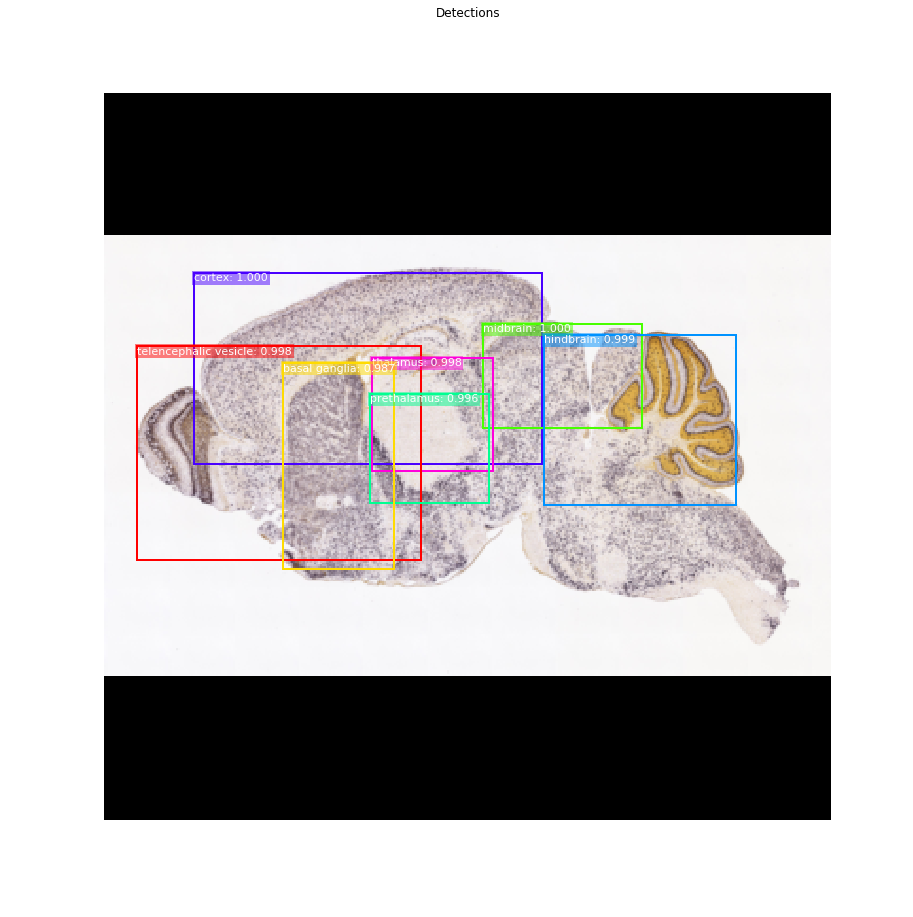

In [100]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids != 0)[0]
det_class_ids = det_class_ids[det_count]
detections = mrcnn['detections'][0, :len(det_count)-1]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=detections[:, :4],
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())